In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from scipy.stats import wasserstein_distance


In [125]:
df = pd.read_csv('peranna2.csv')

In [126]:
df

,Unnamed: 0,decile3,ID,decile1,race,lsat,ugpa,zfygpa,grad,zgpa,...,race1_hisp,race1_other,race1_white,pass_bar_lr,pass_bar_lr_weighted,pass_bar_lr_best,pass_bar_rf,pass_bar_xgb,pass_bar_xgb_r,pass_bar_mlp_best
0,0,10.0,2,10.0,7.0,44.0,3.5,1.33,1,1.88,...,False,False,True,1,1,1,1,1,1,1
1,1,4.0,3,5.0,7.0,29.0,3.5,-0.11,1,-0.57,...,False,False,True,1,0,1,1,1,0,1
2,2,2.0,36,3.0,7.0,36.0,3.5,-0.64,1,-1.12,...,False,False,True,1,0,1,0,0,0,0
3,3,4.0,52,7.0,7.0,39.0,3.5,0.34,1,-0.49,...,False,False,True,1,1,1,1,1,1,1
4,4,8.0,55,9.0,7.0,48.0,3.5,1.02,1,0.76,...,False,False,True,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,22402,1.0,10695,3.0,3.0,26.5,1.8,-0.58,1,-1.49,...,False,False,False,0,0,0,0,0,0,0
22068,22403,1.0,19642,3.0,3.0,19.7,1.8,-0.64,1,-1.36,...,False,False,False,0,0,0,0,0,0,0
22069,22404,8.0,24704,7.0,3.0,36.0,1.8,0.41,1,0.80,...,False,False,False,1,1,1,1,1,1,1
22070,22405,10.0,10000,10.0,7.0,44.0,1.5,1.88,1,1.42,...,False,False,True,1,1,1,1,1,1,1


# detecting bias in the new outputs
Only the features were bias was previously detected will be analyzed

## **Race  -- Disparate Impact**

### Logistic Regression

In [127]:
df_clean = df.dropna().copy()

In [128]:
#df['race1'] = df_copied['race1']
#df["race1"].unique()

In [129]:
df.to_csv('complete_df_with_predictions.csv')

In [130]:
all_results_race = {}


In [131]:
race_groups = ['black', 'hisp', 'asian', 'other']
results = {}

df_clean['race1'] = df['race1'].str.lower().str.strip()

for group in race_groups:
    df_temp = df_clean[df_clean['race1'].isin(['white', group])].copy()
    df_temp['race_bin'] = df_temp['race1'].apply(lambda x: 1 if x == 'white' else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_lr', 'race_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_lr', 'race_bin'])

    if df_numeric['race_bin'].nunique() < 2:
        print(f"Skipping group {group} — only one race_bin present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_lr'],
        protected_attribute_names=['race_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'race_bin': 1}],  # white
        unprivileged_groups=[{'race_bin': 0}]  # current group
    )

    white_scores = df_numeric[df_numeric['race_bin'] == 1]['pass_bar_lr']
    group_scores = df_numeric[df_numeric['race_bin'] == 0]['pass_bar_lr']
    wd = wasserstein_distance(white_scores, group_scores)

    results[group] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

all_results_race['Logistic Regression'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\696510848.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(p

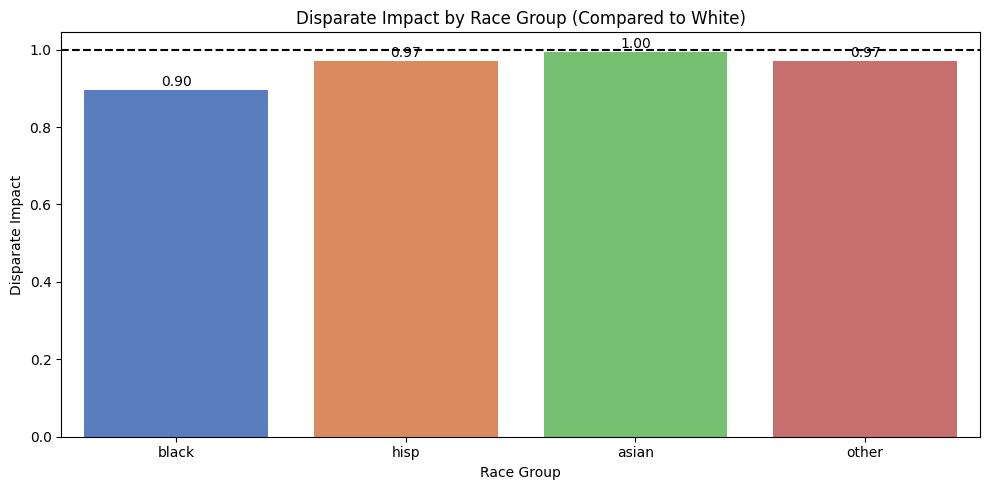

In [132]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Race'})

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Race Group (Compared to White)")
plt.ylabel("Disparate Impact")
plt.xlabel("Race Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### Logistic regression weighted

In [133]:
race_groups = ['black', 'hisp', 'asian', 'other']
results = {}

df_clean['race1'] = df['race1'].str.lower().str.strip()

for group in race_groups:
    df_temp = df_clean[df_clean['race1'].isin(['white', group])].copy()
    df_temp['race_bin'] = df_temp['race1'].apply(lambda x: 1 if x == 'white' else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_lr_weighted', 'race_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_lr_weighted', 'race_bin'])

    if df_numeric['race_bin'].nunique() < 2:
        print(f"Skipping group {group} — only one race_bin present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_lr_weighted'],
        protected_attribute_names=['race_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'race_bin': 1}],  # white
        unprivileged_groups=[{'race_bin': 0}]  # current group
    )

    white_scores = df_numeric[df_numeric['race_bin'] == 1]['pass_bar_lr_weighted']
    group_scores = df_numeric[df_numeric['race_bin'] == 0]['pass_bar_lr_weighted']
    wd = wasserstein_distance(white_scores, group_scores)

    results[group] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }
all_results_race['Logistic Regression Weighted'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\696510848.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(p

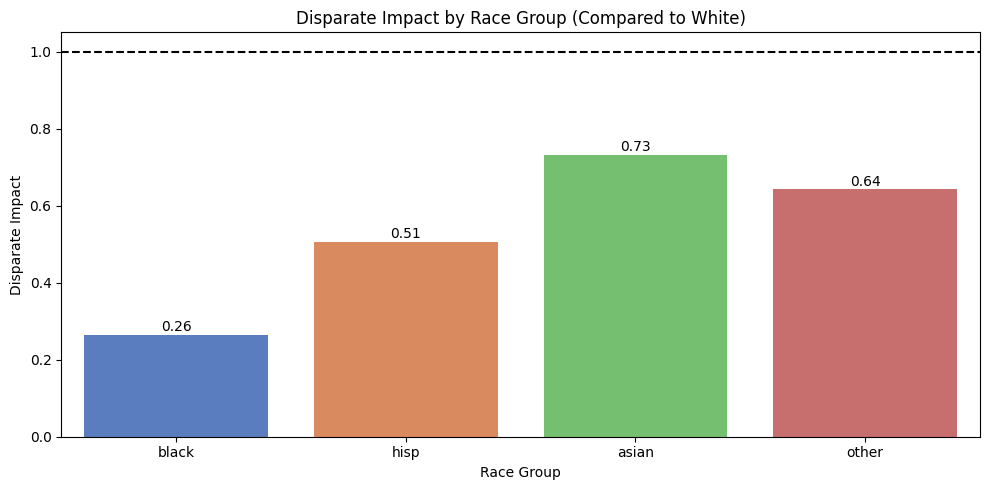

In [134]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Race'})

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Race Group (Compared to White)")
plt.ylabel("Disparate Impact")
plt.xlabel("Race Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### Best LR

In [135]:
race_groups = ['black', 'hisp', 'asian', 'other']
results = {}

df_clean['race1'] = df['race1'].str.lower().str.strip()

for group in race_groups:
    df_temp = df_clean[df_clean['race1'].isin(['white', group])].copy()
    df_temp['race_bin'] = df_temp['race1'].apply(lambda x: 1 if x == 'white' else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_lr_best', 'race_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_lr_best', 'race_bin'])

    if df_numeric['race_bin'].nunique() < 2:
        print(f"Skipping group {group} — only one race_bin present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_lr_best'],
        protected_attribute_names=['race_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'race_bin': 1}],  # white
        unprivileged_groups=[{'race_bin': 0}]  # current group
    )

    white_scores = df_numeric[df_numeric['race_bin'] == 1]['pass_bar_lr_best']
    group_scores = df_numeric[df_numeric['race_bin'] == 0]['pass_bar_lr_best']
    wd = wasserstein_distance(white_scores, group_scores)

    results[group] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

all_results_race['Best Logistic Regression'] = results


C:\Users\annad\AppData\Local\Temp\ipykernel_21264\696510848.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(p

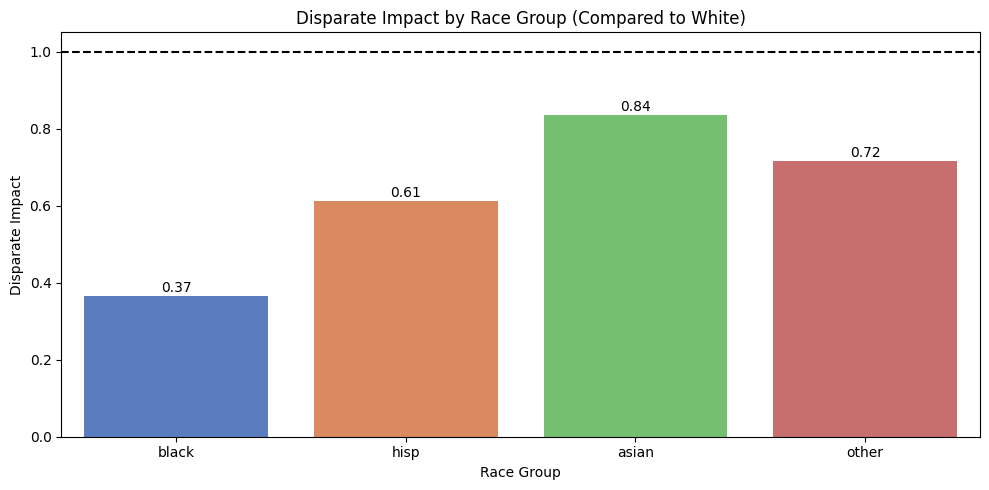

In [136]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Race'})

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Race Group (Compared to White)")
plt.ylabel("Disparate Impact")
plt.xlabel("Race Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### random forest

In [137]:
race_groups = ['black', 'hisp', 'asian', 'other']
results = {}

df_clean['race1'] = df['race1'].str.lower().str.strip()

for group in race_groups:
    df_temp = df_clean[df_clean['race1'].isin(['white', group])].copy()
    df_temp['race_bin'] = df_temp['race1'].apply(lambda x: 1 if x == 'white' else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_rf', 'race_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_rf', 'race_bin'])

    if df_numeric['race_bin'].nunique() < 2:
        print(f"Skipping group {group} — only one race_bin present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_rf'],
        protected_attribute_names=['race_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'race_bin': 1}],  # white
        unprivileged_groups=[{'race_bin': 0}]  # current group
    )

    white_scores = df_numeric[df_numeric['race_bin'] == 1]['pass_bar_rf']
    group_scores = df_numeric[df_numeric['race_bin'] == 0]['pass_bar_rf']
    wd = wasserstein_distance(white_scores, group_scores)

    results[group] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

all_results_race['Random Forest'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\696510848.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(p

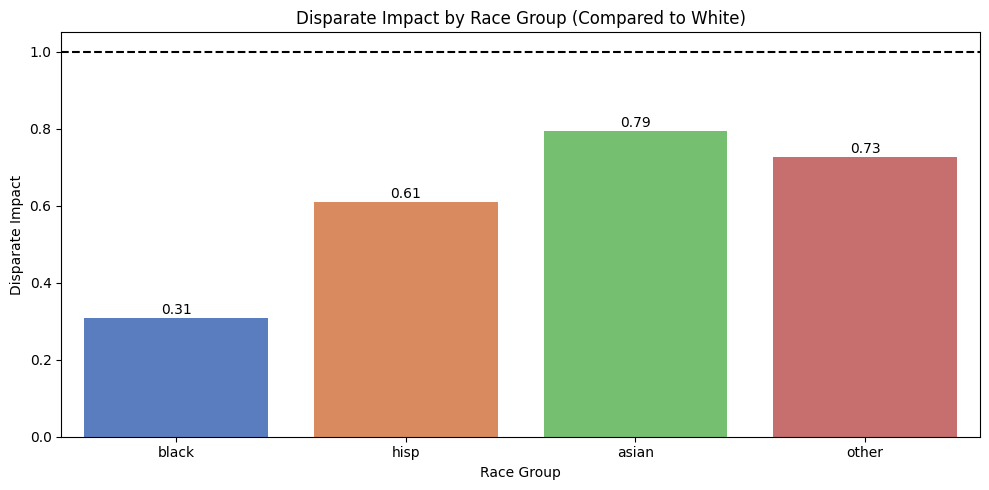

In [138]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Race'})

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Race Group (Compared to White)")
plt.ylabel("Disparate Impact")
plt.xlabel("Race Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### xgboost

C:\Users\annad\AppData\Local\Temp\ipykernel_21264\458475937.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

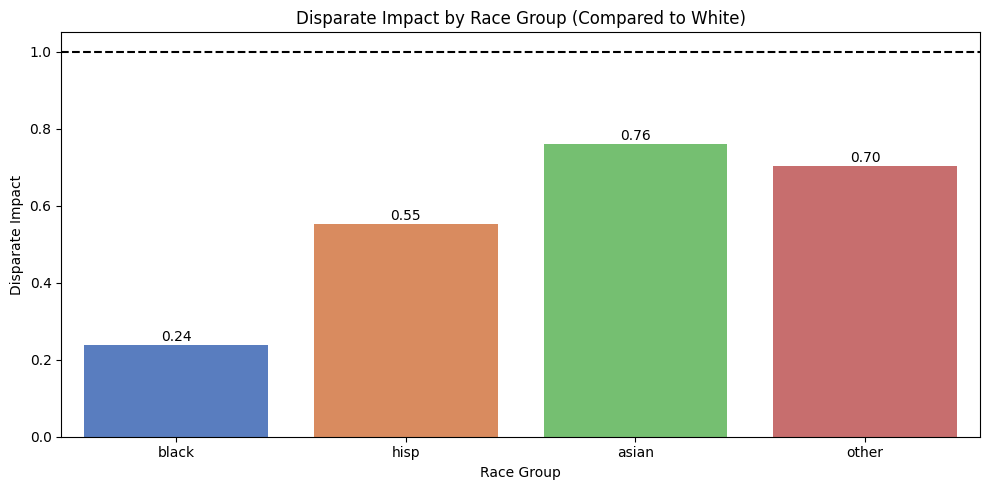

In [139]:
race_groups = ['black', 'hisp', 'asian', 'other']
results = {}

df_clean['race1'] = df['race1'].str.lower().str.strip()

for group in race_groups:
    df_temp = df_clean[df_clean['race1'].isin(['white', group])].copy()
    df_temp['race_bin'] = df_temp['race1'].apply(lambda x: 1 if x == 'white' else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_xgb', 'race_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_xgb', 'race_bin'])

    if df_numeric['race_bin'].nunique() < 2:
        print(f"Skipping group {group} — only one race_bin present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_xgb'],
        protected_attribute_names=['race_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'race_bin': 1}],  # white
        unprivileged_groups=[{'race_bin': 0}]  # current group
    )

    white_scores = df_numeric[df_numeric['race_bin'] == 1]['pass_bar_xgb']
    group_scores = df_numeric[df_numeric['race_bin'] == 0]['pass_bar_xgb']
    wd = wasserstein_distance(white_scores, group_scores)

    results[group] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

all_results_race['XGBoost'] = results

results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Race'})

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Race Group (Compared to White)")
plt.ylabel("Disparate Impact")
plt.xlabel("Race Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()

### xgboost r

In [140]:
race_groups = ['black', 'hisp', 'asian', 'other']
results = {}

df_clean['race1'] = df['race1'].str.lower().str.strip()

for group in race_groups:
    df_temp = df_clean[df_clean['race1'].isin(['white', group])].copy()
    df_temp['race_bin'] = df_temp['race1'].apply(lambda x: 1 if x == 'white' else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_xgb_r', 'race_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_xgb_r', 'race_bin'])

    if df_numeric['race_bin'].nunique() < 2:
        print(f"Skipping group {group} — only one race_bin present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_xgb_r'],
        protected_attribute_names=['race_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'race_bin': 1}],  # white
        unprivileged_groups=[{'race_bin': 0}]  # current group
    )
    white_scores = df_numeric[df_numeric['race_bin'] == 1]['pass_bar_xgb_r']
    group_scores = df_numeric[df_numeric['race_bin'] == 0]['pass_bar_xgb_r']
    wd = wasserstein_distance(white_scores, group_scores)

    results[group] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

all_results_race['XGBoost R'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\696510848.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(p

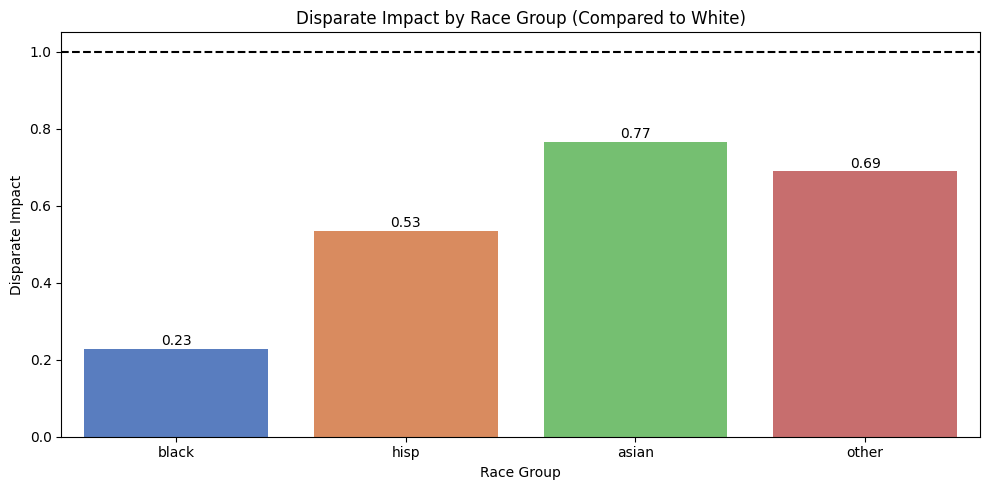

In [141]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Race'})

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Race Group (Compared to White)")
plt.ylabel("Disparate Impact")
plt.xlabel("Race Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### multilayer preceptron

In [142]:
race_groups = ['black', 'hisp', 'asian', 'other']
results = {}

df_clean['race1'] = df['race1'].str.lower().str.strip()

for group in race_groups:
    df_temp = df_clean[df_clean['race1'].isin(['white', group])].copy()
    df_temp['race_bin'] = df_temp['race1'].apply(lambda x: 1 if x == 'white' else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_mlp_best', 'race_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_mlp_best', 'race_bin'])

    if df_numeric['race_bin'].nunique() < 2:
        print(f"Skipping group {group} — only one race_bin present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_mlp_best'],
        protected_attribute_names=['race_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'race_bin': 1}],  # white
        unprivileged_groups=[{'race_bin': 0}]  # current group
    )
    white_scores = df_numeric[df_numeric['race_bin'] == 1]['pass_bar_mlp_best']
    group_scores = df_numeric[df_numeric['race_bin'] == 0]['pass_bar_mlp_best']
    wd = wasserstein_distance(white_scores, group_scores)

    results[group] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

all_results_race['MLP'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\3024009592.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

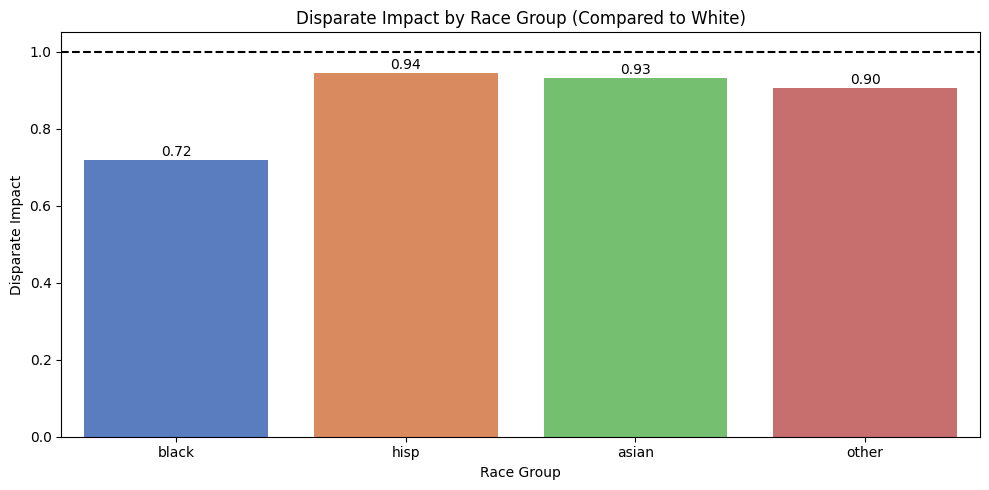

In [143]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Race'})

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Race Group (Compared to White)")
plt.ylabel("Disparate Impact")
plt.xlabel("Race Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()

In [144]:
all_results_race

{'Logistic Regression': {'black': {'Disparate Impact': 0.8966072449715323,
   'Statistical Parity Difference': -0.10332555141778943,
   'Wasserstein Distance': 0.10332555141778947},
  'hisp': {'Disparate Impact': 0.970928117201964,
   'Statistical Parity Difference': -0.02905298654662347,
   'Wasserstein Distance': 0.02905298654662346},
  'asian': {'Disparate Impact': 0.9950161136746503,
   'Statistical Parity Difference': -0.004980646880224371,
   'Wasserstein Distance': 0.004980646880224391},
  'other': {'Disparate Impact': 0.970928117201964,
   'Statistical Parity Difference': -0.02905298654662347,
   'Wasserstein Distance': 0.02905298654662346}},
 'Logistic Regression Weighted': {'black': {'Disparate Impact': 0.26384326193432883,
   'Statistical Parity Difference': -0.6015415746104817,
   'Wasserstein Distance': 0.6015415746104817},
  'hisp': {'Disparate Impact': 0.5064767937750954,
   'Statistical Parity Difference': -0.4032765187470973,
   'Wasserstein Distance': 0.40327651874709

## **Family income -- Disparate Impact**

In [145]:
results_all_faminc = {}

### Logistic Regression

In [146]:
df['fam_inc'].unique()

array([5., 4., 1., 3., 2.])

- 1: low income
- 5: high income

In [147]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = {}

df_clean = df_clean.dropna(subset=['fam_inc'])

for group in income_groups:
    df_temp = df_clean[df_clean['fam_inc'].isin([5.0, group])].copy()
    df_temp['income_bin'] = df_temp['fam_inc'].apply(lambda x: 1 if x == 5.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_lr', 'income_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_lr', 'income_bin'])

    if df_numeric['income_bin'].nunique() < 2:
        print(f"Skipping income group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_lr'],
        protected_attribute_names=['income_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'income_bin': 1}],  # high income (5)
        unprivileged_groups=[{'income_bin': 0}]  # current group
    )

    high_income_scores = df_numeric[df_numeric['income_bin'] == 1]['pass_bar_lr']
    current_group_scores = df_numeric[df_numeric['income_bin'] == 0]['pass_bar_lr']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_faminc['Logistic Regression'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\1140888817.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.ge

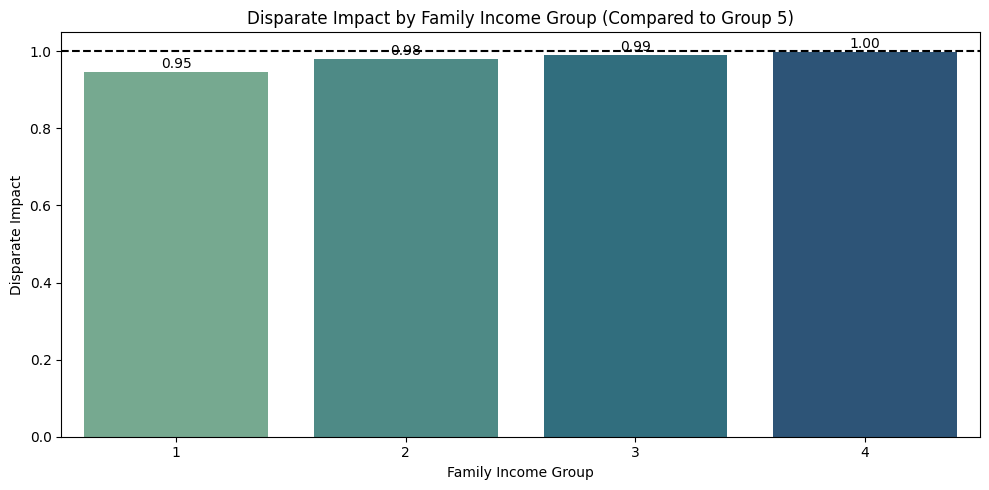

In [148]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Income Group'})
results_df = results_df.sort_values(by='Income Group')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Family Income Group (Compared to Group 5)")
plt.ylabel("Disparate Impact")
plt.xlabel("Family Income Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### Weighted logistic regression

In [149]:
df['fam_inc'].unique()

array([5., 4., 1., 3., 2.])

- 1: low income
- 5: high income

In [150]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = {}

df_clean = df_clean.dropna(subset=['fam_inc'])

for group in income_groups:
    df_temp = df_clean[df_clean['fam_inc'].isin([5.0, group])].copy()
    df_temp['income_bin'] = df_temp['fam_inc'].apply(lambda x: 1 if x == 5.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_lr_weighted', 'income_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_lr_weighted', 'income_bin'])

    if df_numeric['income_bin'].nunique() < 2:
        print(f"Skipping income group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_lr_weighted'],
        protected_attribute_names=['income_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'income_bin': 1}],  # high income (5)
        unprivileged_groups=[{'income_bin': 0}]  # current group
    )

    high_income_scores = df_numeric[df_numeric['income_bin'] == 1]['pass_bar_lr_weighted']
    current_group_scores = df_numeric[df_numeric['income_bin'] == 0]['pass_bar_lr_weighted']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_faminc['Logistic Regression Weighted'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\1140888817.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.ge

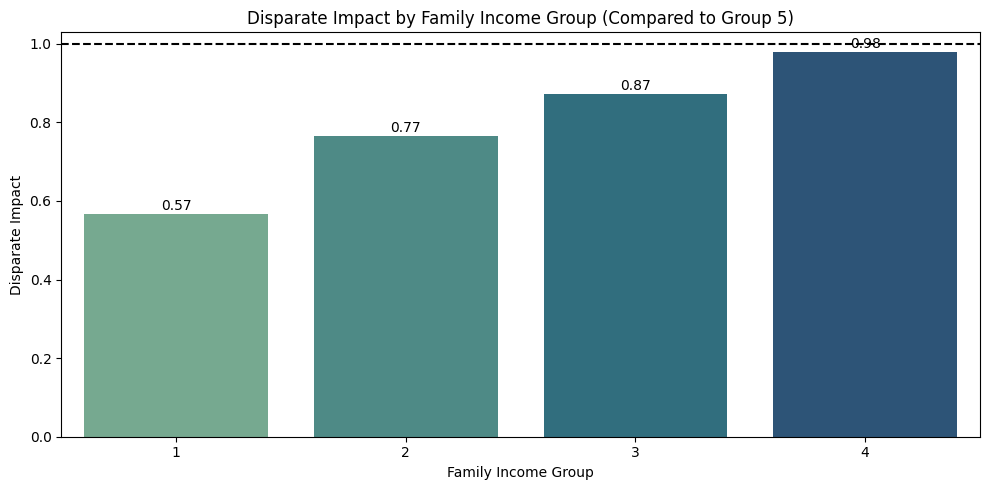

In [151]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Income Group'})
results_df = results_df.sort_values(by='Income Group')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Family Income Group (Compared to Group 5)")
plt.ylabel("Disparate Impact")
plt.xlabel("Family Income Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### Best Logistic Regression

In [152]:
df['fam_inc'].unique()

array([5., 4., 1., 3., 2.])

- 1: low income
- 5: high income

In [153]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = {}

df_clean = df_clean.dropna(subset=['fam_inc'])

for group in income_groups:
    df_temp = df_clean[df_clean['fam_inc'].isin([5.0, group])].copy()
    df_temp['income_bin'] = df_temp['fam_inc'].apply(lambda x: 1 if x == 5.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_lr_best', 'income_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_lr_best', 'income_bin'])

    if df_numeric['income_bin'].nunique() < 2:
        print(f"Skipping income group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_lr_best'],
        protected_attribute_names=['income_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'income_bin': 1}],  # high income (5)
        unprivileged_groups=[{'income_bin': 0}]  # current group
    )

    high_income_scores = df_numeric[df_numeric['income_bin'] == 1]['pass_bar_lr_best']
    current_group_scores = df_numeric[df_numeric['income_bin'] == 0]['pass_bar_lr_best']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_faminc['Logistic Regression Best'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\1140888817.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.ge

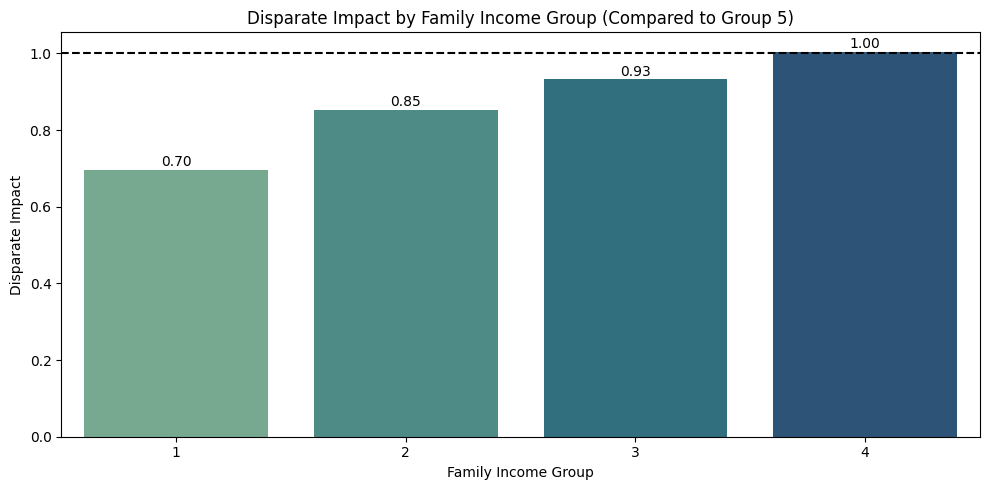

In [154]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Income Group'})
results_df = results_df.sort_values(by='Income Group')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Family Income Group (Compared to Group 5)")
plt.ylabel("Disparate Impact")
plt.xlabel("Family Income Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### Random Forest

In [155]:
df['fam_inc'].unique()

array([5., 4., 1., 3., 2.])

- 1: low income
- 5: high income

In [156]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = {}

df_clean = df_clean.dropna(subset=['fam_inc'])

for group in income_groups:
    df_temp = df_clean[df_clean['fam_inc'].isin([5.0, group])].copy()
    df_temp['income_bin'] = df_temp['fam_inc'].apply(lambda x: 1 if x == 5.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_rf', 'income_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_rf', 'income_bin'])

    if df_numeric['income_bin'].nunique() < 2:
        print(f"Skipping income group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_rf'],
        protected_attribute_names=['income_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'income_bin': 1}],  # high income (5)
        unprivileged_groups=[{'income_bin': 0}]  # current group
    )

    high_income_scores = df_numeric[df_numeric['income_bin'] == 1]['pass_bar_rf']
    current_group_scores = df_numeric[df_numeric['income_bin'] == 0]['pass_bar_rf']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_faminc['Random Forest'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\1140888817.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.ge

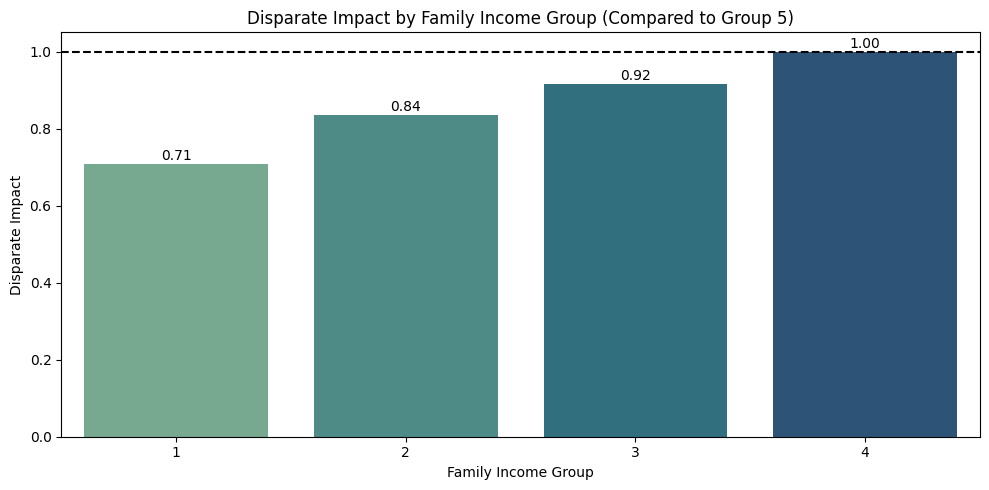

In [157]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Income Group'})
results_df = results_df.sort_values(by='Income Group')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Family Income Group (Compared to Group 5)")
plt.ylabel("Disparate Impact")
plt.xlabel("Family Income Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### XGBoost

In [158]:
df['fam_inc'].unique()

array([5., 4., 1., 3., 2.])

- 1: low income
- 5: high income

In [159]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = {}

df_clean = df_clean.dropna(subset=['fam_inc'])

for group in income_groups:
    df_temp = df_clean[df_clean['fam_inc'].isin([5.0, group])].copy()
    df_temp['income_bin'] = df_temp['fam_inc'].apply(lambda x: 1 if x == 5.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_xgb', 'income_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_xgb', 'income_bin'])

    if df_numeric['income_bin'].nunique() < 2:
        print(f"Skipping income group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_xgb'],
        protected_attribute_names=['income_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'income_bin': 1}],  # high income (5)
        unprivileged_groups=[{'income_bin': 0}]  # current group
    )

    high_income_scores = df_numeric[df_numeric['income_bin'] == 1]['pass_bar_xgb']
    current_group_scores = df_numeric[df_numeric['income_bin'] == 0]['pass_bar_xgb']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_faminc['XGBoost'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\1140888817.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.ge

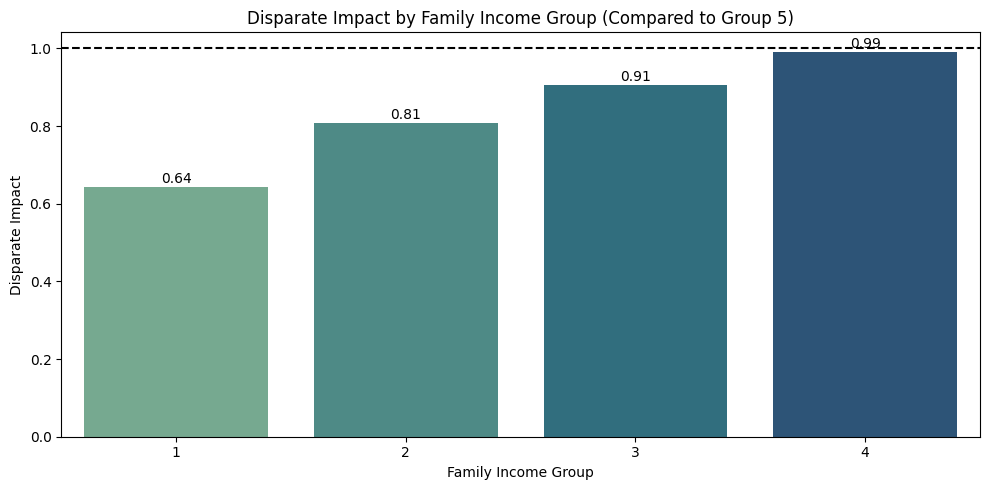

In [160]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Income Group'})
results_df = results_df.sort_values(by='Income Group')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Family Income Group (Compared to Group 5)")
plt.ylabel("Disparate Impact")
plt.xlabel("Family Income Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### Best XGBoost

In [161]:
df['fam_inc'].unique()

array([5., 4., 1., 3., 2.])

- 1: low income
- 5: high income

In [162]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = {}

df_clean = df_clean.dropna(subset=['fam_inc'])

for group in income_groups:
    df_temp = df_clean[df_clean['fam_inc'].isin([5.0, group])].copy()
    df_temp['income_bin'] = df_temp['fam_inc'].apply(lambda x: 1 if x == 5.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_xgb_r', 'income_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_xgb_r', 'income_bin'])

    if df_numeric['income_bin'].nunique() < 2:
        print(f"Skipping income group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_xgb_r'],
        protected_attribute_names=['income_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'income_bin': 1}],  # high income (5)
        unprivileged_groups=[{'income_bin': 0}]  # current group
    )

    high_income_scores = df_numeric[df_numeric['income_bin'] == 1]['pass_bar_xgb_r']
    current_group_scores = df_numeric[df_numeric['income_bin'] == 0]['pass_bar_xgb_r']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_faminc['XGBoost R'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\1140888817.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.ge

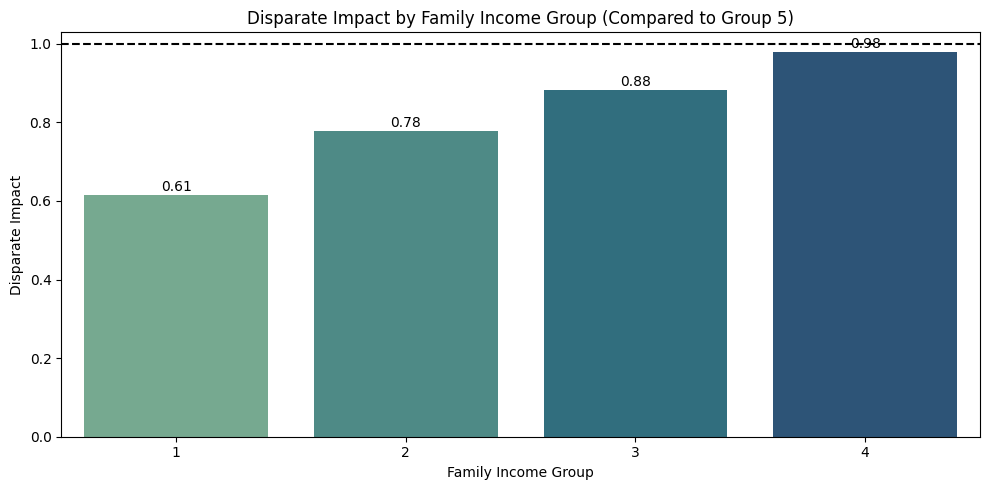

In [163]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Income Group'})
results_df = results_df.sort_values(by='Income Group')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Family Income Group (Compared to Group 5)")
plt.ylabel("Disparate Impact")
plt.xlabel("Family Income Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### Multilayer preceptron

In [164]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = {}

df_clean = df_clean.dropna(subset=['fam_inc'])

for group in income_groups:
    df_temp = df_clean[df_clean['fam_inc'].isin([5.0, group])].copy()
    df_temp['income_bin'] = df_temp['fam_inc'].apply(lambda x: 1 if x == 5.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_mlp_best', 'income_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_mlp_best', 'income_bin'])

    if df_numeric['income_bin'].nunique() < 2:
        print(f"Skipping income group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_mlp_best'],
        protected_attribute_names=['income_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'income_bin': 1}],  # high income (5)
        unprivileged_groups=[{'income_bin': 0}]  # current group
    )

    high_income_scores = df_numeric[df_numeric['income_bin'] == 1]['pass_bar_mlp_best']
    current_group_scores = df_numeric[df_numeric['income_bin'] == 0]['pass_bar_mlp_best']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_faminc['MLP'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\1140888817.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.ge

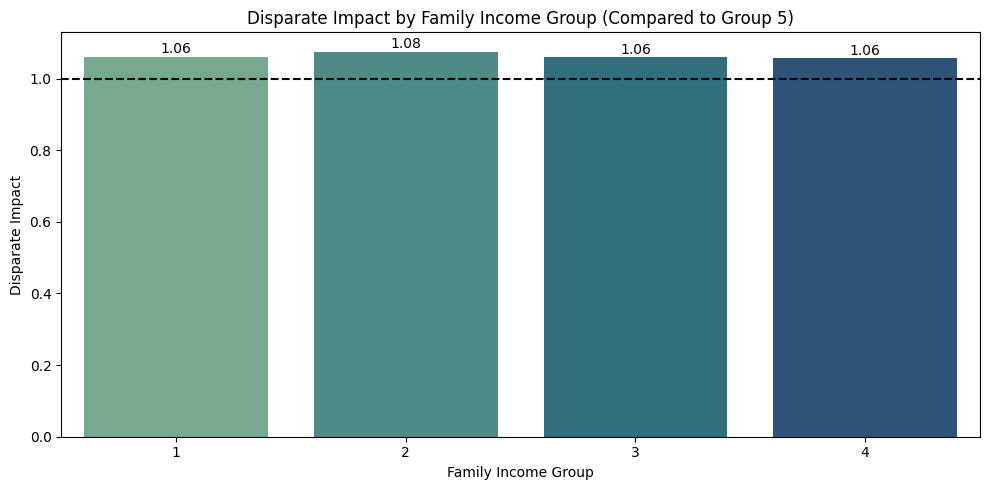

In [165]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Income Group'})
results_df = results_df.sort_values(by='Income Group')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Family Income Group (Compared to Group 5)")
plt.ylabel("Disparate Impact")
plt.xlabel("Family Income Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


In [166]:
results_all_faminc

{'Logistic Regression': {1: {'Disparate Impact': 0.9467791328509859,
   'Statistical Parity Difference': -0.05310344659270072,
   'Wasserstein Distance': 0.05310344659270071},
  2: {'Disparate Impact': 0.9796740635205493,
   'Statistical Parity Difference': -0.020281091611321744,
   'Wasserstein Distance': 0.02028109161132173},
  3: {'Disparate Impact': 0.991146144629363,
   'Statistical Parity Difference': -0.0088343212164822,
   'Wasserstein Distance': 0.008834321216482203},
  4: {'Disparate Impact': 0.9991268070353562,
   'Statistical Parity Difference': -0.0008712664495535982,
   'Wasserstein Distance': 0.0008712664495535705}},
 'Logistic Regression Weighted': {1: {'Disparate Impact': 0.5668391715003752,
   'Statistical Parity Difference': -0.3550341925816009,
   'Wasserstein Distance': 0.35503419258160096},
  2: {'Disparate Impact': 0.7654032095179917,
   'Statistical Parity Difference': -0.19228396616451426,
   'Wasserstein Distance': 0.19228396616451424},
  3: {'Disparate Impact

## **Tier -- Disparate Impact**

In [167]:
results_all_tier = {}

### Logistic Regression

In [168]:
df['tier'].unique()

array([4., 2., 3., 5., 1., 6.])

In [169]:
results_tier = {}

In [170]:
tier_groups = [1.0, 2.0, 3.0, 4.0, 5.0]
results = {}

df_clean = df_clean.dropna(subset=['tier'])

for group in tier_groups:
    df_temp = df_clean[df_clean['tier'].isin([6.0, group])].copy()
    df_temp['tier_bin'] = df_temp['tier'].apply(lambda x: 1 if x == 6.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_lr', 'tier_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_lr', 'tier_bin'])

    if df_numeric['tier_bin'].nunique() < 2:
        print(f"Skipping tier group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_lr'],
        protected_attribute_names=['tier_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'tier_bin': 1}],   # Tier 6 (privileged)
        unprivileged_groups=[{'tier_bin': 0}]  # Current tier (1–5)
    )

    high_income_scores = df_numeric[df_numeric['tier_bin'] == 1]['pass_bar_lr']
    current_group_scores = df_numeric[df_numeric['tier_bin'] == 0]['pass_bar_lr']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_tier['Logistic Regression'] = results




C:\Users\annad\AppData\Local\Temp\ipykernel_21264\499817271.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(p

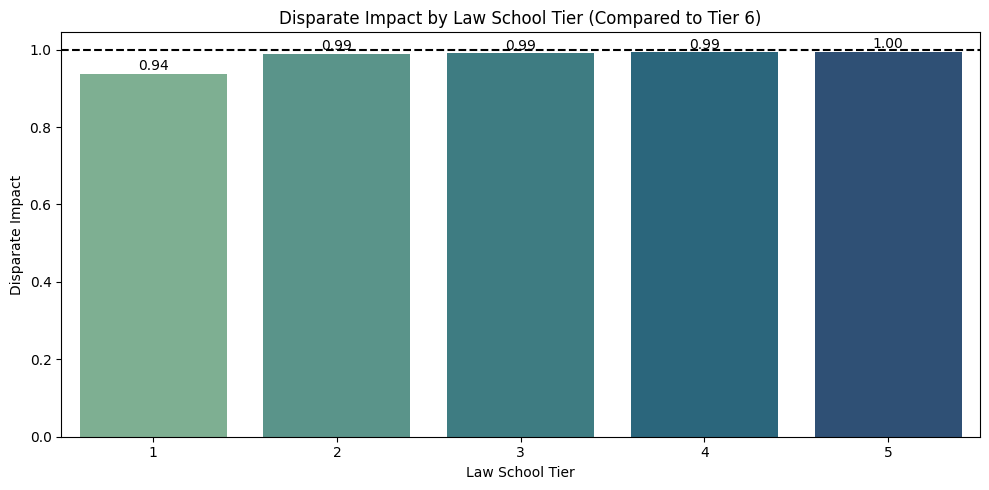

In [171]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Tier'})
results_df = results_df.sort_values(by='Tier')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Law School Tier (Compared to Tier 6)")
plt.ylabel("Disparate Impact")
plt.xlabel("Law School Tier")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### Weighted Logistic Regression

In [172]:
df['tier'].unique()

array([4., 2., 3., 5., 1., 6.])

In [173]:
tier_groups = [1.0, 2.0, 3.0, 4.0, 5.0]
results = {}

df_clean = df_clean.dropna(subset=['tier'])

for group in tier_groups:
    df_temp = df_clean[df_clean['tier'].isin([6.0, group])].copy()
    df_temp['tier_bin'] = df_temp['tier'].apply(lambda x: 1 if x == 6.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_lr_weighted', 'tier_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_lr_weighted', 'tier_bin'])

    if df_numeric['tier_bin'].nunique() < 2:
        print(f"Skipping tier group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_lr_weighted'],
        protected_attribute_names=['tier_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'tier_bin': 1}],   # Tier 6 (privileged)
        unprivileged_groups=[{'tier_bin': 0}]  # Current tier (1–5)
    )

    high_income_scores = df_numeric[df_numeric['tier_bin'] == 1]['pass_bar_lr_weighted']
    current_group_scores = df_numeric[df_numeric['tier_bin'] == 0]['pass_bar_lr_weighted']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_tier['Logistic Regression Weighted'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\499817271.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(p

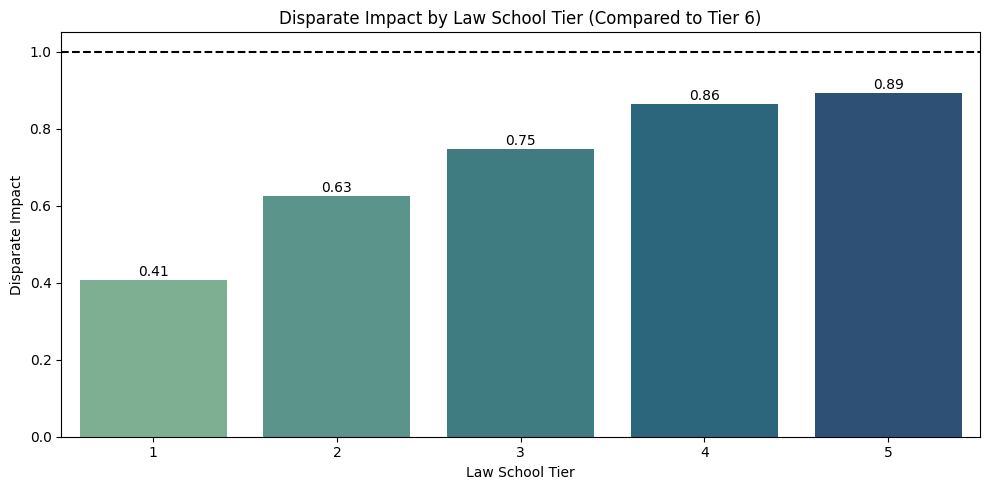

In [174]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Tier'})
results_df = results_df.sort_values(by='Tier')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Law School Tier (Compared to Tier 6)")
plt.ylabel("Disparate Impact")
plt.xlabel("Law School Tier")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### Best Logistic Regression

In [175]:
df['tier'].unique()

array([4., 2., 3., 5., 1., 6.])

In [176]:
tier_groups = [1.0, 2.0, 3.0, 4.0, 5.0]
results = {}

df_clean = df_clean.dropna(subset=['tier'])

for group in tier_groups:
    df_temp = df_clean[df_clean['tier'].isin([6.0, group])].copy()
    df_temp['tier_bin'] = df_temp['tier'].apply(lambda x: 1 if x == 6.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_lr_best', 'tier_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_lr_best', 'tier_bin'])

    if df_numeric['tier_bin'].nunique() < 2:
        print(f"Skipping tier group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_lr_best'],
        protected_attribute_names=['tier_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'tier_bin': 1}],   # Tier 6 (privileged)
        unprivileged_groups=[{'tier_bin': 0}]  # Current tier (1–5)
    )

    high_income_scores = df_numeric[df_numeric['tier_bin'] == 1]['pass_bar_lr_best']
    current_group_scores = df_numeric[df_numeric['tier_bin'] == 0]['pass_bar_lr_best']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_tier['Logistic Regression Best'] = results

C:\Users\annad\AppData\Local\Temp\ipykernel_21264\499817271.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(p

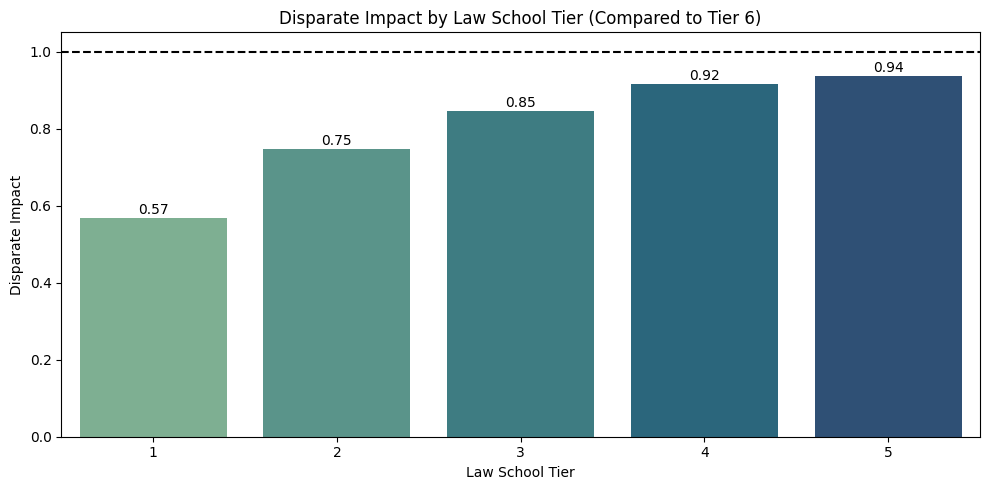

In [177]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Tier'})
results_df = results_df.sort_values(by='Tier')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Law School Tier (Compared to Tier 6)")
plt.ylabel("Disparate Impact")
plt.xlabel("Law School Tier")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### Random Forest

In [178]:
df['tier'].unique()

array([4., 2., 3., 5., 1., 6.])

In [179]:
tier_groups = [1.0, 2.0, 3.0, 4.0, 5.0]
results = {}

df_clean = df_clean.dropna(subset=['tier'])

for group in tier_groups:
    df_temp = df_clean[df_clean['tier'].isin([6.0, group])].copy()
    df_temp['tier_bin'] = df_temp['tier'].apply(lambda x: 1 if x == 6.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_rf', 'tier_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_rf', 'tier_bin'])

    if df_numeric['tier_bin'].nunique() < 2:
        print(f"Skipping tier group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_rf'],
        protected_attribute_names=['tier_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'tier_bin': 1}],   # Tier 6 (privileged)
        unprivileged_groups=[{'tier_bin': 0}]  # Current tier (1–5)
    )

    high_income_scores = df_numeric[df_numeric['tier_bin'] == 1]['pass_bar_rf']
    current_group_scores = df_numeric[df_numeric['tier_bin'] == 0]['pass_bar_rf']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_tier['Random Forest'] = results


C:\Users\annad\AppData\Local\Temp\ipykernel_21264\499817271.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(p

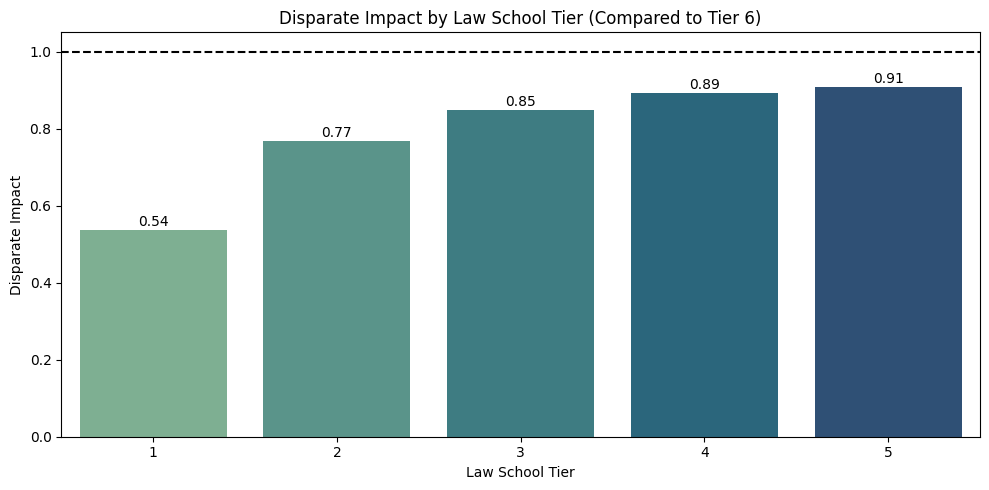

In [180]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Tier'})
results_df = results_df.sort_values(by='Tier')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Law School Tier (Compared to Tier 6)")
plt.ylabel("Disparate Impact")
plt.xlabel("Law School Tier")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### XGBoost

In [181]:
df['tier'].unique()

array([4., 2., 3., 5., 1., 6.])

In [182]:
tier_groups = [1.0, 2.0, 3.0, 4.0, 5.0]
results = {}

df_clean = df_clean.dropna(subset=['tier'])

for group in tier_groups:
    df_temp = df_clean[df_clean['tier'].isin([6.0, group])].copy()
    df_temp['tier_bin'] = df_temp['tier'].apply(lambda x: 1 if x == 6.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_xgb', 'tier_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_xgb', 'tier_bin'])

    if df_numeric['tier_bin'].nunique() < 2:
        print(f"Skipping tier group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_xgb'],
        protected_attribute_names=['tier_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'tier_bin': 1}],   # Tier 6 (privileged)
        unprivileged_groups=[{'tier_bin': 0}]  # Current tier (1–5)
    )

    high_income_scores = df_numeric[df_numeric['tier_bin'] == 1]['pass_bar_xgb']
    current_group_scores = df_numeric[df_numeric['tier_bin'] == 0]['pass_bar_xgb']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_tier['XGBoost'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\499817271.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(p

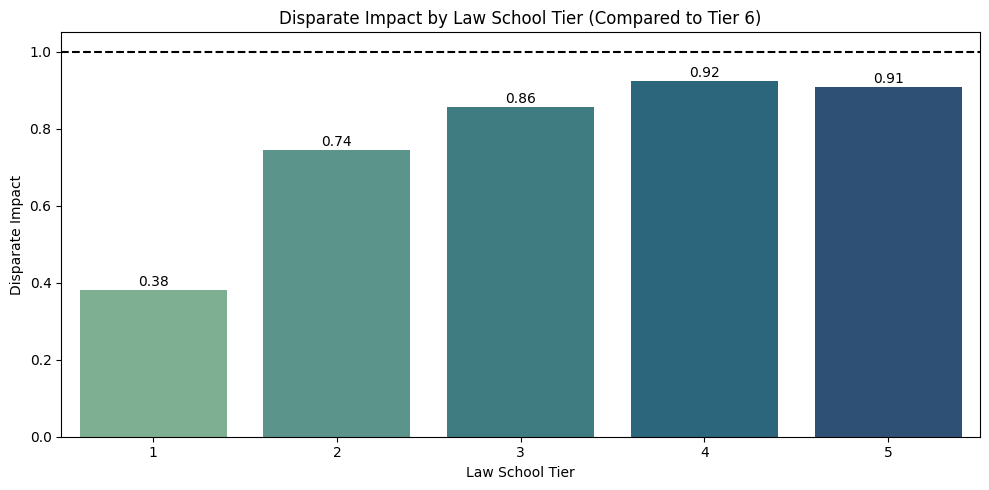

In [183]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Tier'})
results_df = results_df.sort_values(by='Tier')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Law School Tier (Compared to Tier 6)")
plt.ylabel("Disparate Impact")
plt.xlabel("Law School Tier")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### XGBoost R

In [184]:
df['tier'].unique()

array([4., 2., 3., 5., 1., 6.])

In [185]:
tier_groups = [1.0, 2.0, 3.0, 4.0, 5.0]
results = {}

df_clean = df_clean.dropna(subset=['tier'])

for group in tier_groups:
    df_temp = df_clean[df_clean['tier'].isin([6.0, group])].copy()
    df_temp['tier_bin'] = df_temp['tier'].apply(lambda x: 1 if x == 6.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_xgb_r', 'tier_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_xgb_r', 'tier_bin'])

    if df_numeric['tier_bin'].nunique() < 2:
        print(f"Skipping tier group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_xgb_r'],
        protected_attribute_names=['tier_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'tier_bin': 1}],   # Tier 6 (privileged)
        unprivileged_groups=[{'tier_bin': 0}]  # Current tier (1–5)
    )

    high_income_scores = df_numeric[df_numeric['tier_bin'] == 1]['pass_bar_xgb_r']
    current_group_scores = df_numeric[df_numeric['tier_bin'] == 0]['pass_bar_xgb_r']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_tier['XGBoost R'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\499817271.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(p

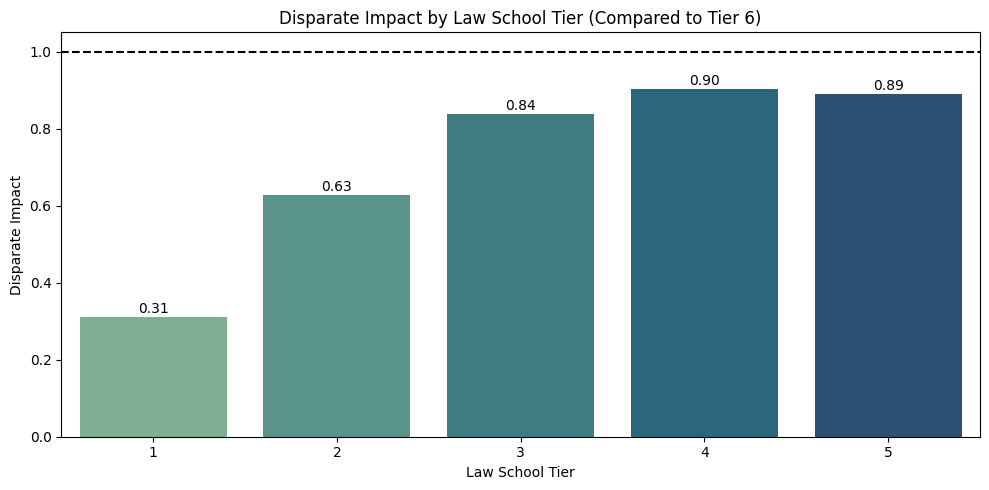

In [186]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Tier'})
results_df = results_df.sort_values(by='Tier')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Law School Tier (Compared to Tier 6)")
plt.ylabel("Disparate Impact")
plt.xlabel("Law School Tier")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### Multilayer perceptron

In [195]:
tier_groups = [1.0, 2.0, 3.0, 4.0, 5.0]
results = {}

df_clean = df_clean.dropna(subset=['tier'])

for group in tier_groups:
    df_temp = df_clean[df_clean['tier'].isin([6.0, group])].copy()
    df_temp['tier_bin'] = df_temp['tier'].apply(lambda x: 1 if x == 6.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_mlp_best', 'tier_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_mlp_best', 'tier_bin'])

    if df_numeric['tier_bin'].nunique() < 2:
        print(f"Skipping tier group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_mlp_best'],
        protected_attribute_names=['tier_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'tier_bin': 1}],   # Tier 6 (privileged)
        unprivileged_groups=[{'tier_bin': 0}]  # Current tier (1–5)
    )

    high_income_scores = df_numeric[df_numeric['tier_bin'] == 1]['pass_bar_mlp_best']
    current_group_scores = df_numeric[df_numeric['tier_bin'] == 0]['pass_bar_mlp_best']
    wd = wasserstein_distance(high_income_scores, current_group_scores)

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Wasserstein Distance': wd
    }

results_all_tier['MLP'] = results



C:\Users\annad\AppData\Local\Temp\ipykernel_21264\4019024752.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

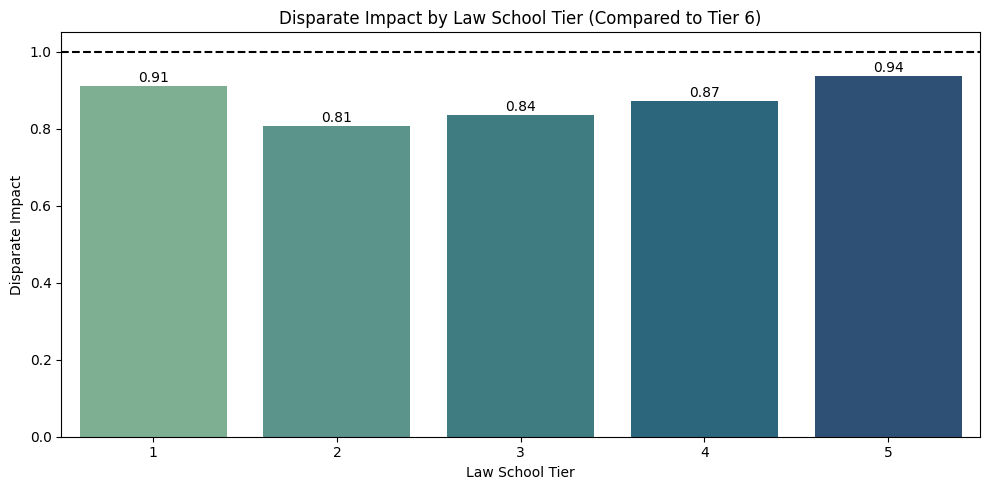

In [196]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Tier'})
results_df = results_df.sort_values(by='Tier')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Law School Tier (Compared to Tier 6)")
plt.ylabel("Disparate Impact")
plt.xlabel("Law School Tier")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()

In [188]:
results_all_tier

{'Logistic Regression': {1: {'Disparate Impact': 0.936426116838488,
   'Statistical Parity Difference': -0.06357388316151202,
   'Wasserstein Distance': 0.06357388316151202},
  2: {'Disparate Impact': 0.9886295631358468,
   'Statistical Parity Difference': -0.011370436864153177,
   'Wasserstein Distance': 0.011370436864153202},
  3: {'Disparate Impact': 0.9903411941796287,
   'Statistical Parity Difference': -0.009658805820371263,
   'Wasserstein Distance': 0.0096588058203713},
  4: {'Disparate Impact': 0.9928452579034942,
   'Statistical Parity Difference': -0.007154742096505795,
   'Wasserstein Distance': 0.007154742096505824},
  5: {'Disparate Impact': 0.9950235725510739,
   'Statistical Parity Difference': -0.004976427448926124,
   'Wasserstein Distance': 0.00497642744892614}},
 'Logistic Regression Weighted': {1: {'Disparate Impact': 0.40627101824797396,
   'Statistical Parity Difference': -0.5499124298545264,
   'Wasserstein Distance': 0.5499124298545264},
  2: {'Disparate Impact

## **Gender -- WD**

### Logistic Regression

In [189]:
from scipy.stats import wasserstein_distance

df_clean = df.copy()

privileged_group = df_clean[df_clean["male"] == 1]["pass_bar_lr"]  
unprivileged_group = df_clean[df_clean["male"] == 0]["pass_bar_lr"]  

wasserstein_dist = wasserstein_distance(privileged_group, unprivileged_group)
print(f"Wasserstein Distance (Gender): {wasserstein_dist:.4f}")


Wasserstein Distance (Gender): 0.0048


### Logistic Regression Weighted

In [190]:
from scipy.stats import wasserstein_distance

df_clean = df.copy()

privileged_group = df_clean[df_clean["male"] == 1]["pass_bar_lr_weighted"]  
unprivileged_group = df_clean[df_clean["male"] == 0]["pass_bar_lr_weighted"]  

wasserstein_dist = wasserstein_distance(privileged_group, unprivileged_group)
print(f"Wasserstein Distance (Gender): {wasserstein_dist:.4f}")


Wasserstein Distance (Gender): 0.0128


### Logistic Regression Best

In [191]:
from scipy.stats import wasserstein_distance

df_clean = df.copy()

privileged_group = df_clean[df_clean["male"] == 1]["pass_bar_lr_best"]  
unprivileged_group = df_clean[df_clean["male"] == 0]["pass_bar_lr_best"]  

wasserstein_dist = wasserstein_distance(privileged_group, unprivileged_group)
print(f"Wasserstein Distance (Gender): {wasserstein_dist:.4f}")


Wasserstein Distance (Gender): 0.0262


### Random Forest

In [192]:
from scipy.stats import wasserstein_distance

df_clean = df.copy()

privileged_group = df_clean[df_clean["male"] == 1]["pass_bar_rf"]  
unprivileged_group = df_clean[df_clean["male"] == 0]["pass_bar_rf"]  

wasserstein_dist = wasserstein_distance(privileged_group, unprivileged_group)
print(f"Wasserstein Distance (Gender): {wasserstein_dist:.4f}")


Wasserstein Distance (Gender): 0.0159


### XGBoost

In [193]:
from scipy.stats import wasserstein_distance

df_clean = df.copy()

privileged_group = df_clean[df_clean["male"] == 1]["pass_bar_xgb"]  
unprivileged_group = df_clean[df_clean["male"] == 0]["pass_bar_xgb"]  

wasserstein_dist = wasserstein_distance(privileged_group, unprivileged_group)
print(f"Wasserstein Distance (Gender): {wasserstein_dist:.4f}")


Wasserstein Distance (Gender): 0.0209


### XGBoost R

In [194]:
from scipy.stats import wasserstein_distance

df_clean = df.copy()

privileged_group = df_clean[df_clean["male"] == 1]["pass_bar_xgb_r"]  
unprivileged_group = df_clean[df_clean["male"] == 0]["pass_bar_xgb_r"]  

wasserstein_dist = wasserstein_distance(privileged_group, unprivileged_group)
print(f"Wasserstein Distance (Gender): {wasserstein_dist:.4f}")


Wasserstein Distance (Gender): 0.0314


## Final considerations

This shows that the bias was made much worse after implementing the Machine Learning (and Deep Learning) algorithms. This pehomemnon has been studied greatly in research, and it is not an uncommon occurrence. Instead for gender, which is the variable for which usually bias is observed first, the results remain unbiased.

We want to point out that bias seems to be strong especially in XGBoost and Random Forest, for most of the features. Logistic Regression, especially in its standard form, seems to be slightly less affected, and the Multilayer perceptron instead seems to be almost untouched. This makes it, for now, the best technique to implement.

It is also important to notice how the race feature seems to be the most biased, which is notable also from the distribution of the feature in the original dataset. This could be a case of both representation and historical bias. 

To summarize: 
Given the nature of the models used and tried, the following are the results: 
- for pure logistic regression, the bias is not harsh and reflects what was observed in the og dataset
- for weighted lr, lr with grid search, rf, xgboost and r xgboost the bias is greatly amplified for the features of race, tier and family income, which should therefore be further studied. 
- to keep everything simple, we will carry on the analysis using only the best performing models, which are Logistic Regression with Grid Search and Weights, Random Forest and R XGBoost 

Literature: 
Zhao et al. (2017) showed that even perfectly balanced datasets can lead to biased predictions when models overfit spurious correlations.